# Gene Panel Analysis and VAE-based Anomaly Detection

This notebook investigates how different **gene panels** affect:

- supervised cancer vs normal classification, and  
- unsupervised VAE-based anomaly detection using reconstruction error.

We will:

1. Build a **cancer-oriented gene panel** using L1-regularized logistic regression.  
2. Build **normal-oriented gene panels** using a Δmean/variance score between normals and tumors.  
3. Train a **VAE only on normal samples** and evaluate anomaly detection performance for each panel.

This first cell sets up the Python environment, imports required libraries, and fixes random seeds for reproducibility.

In [1]:
# Cell 1: Imports and global configuration

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    ConfusionMatrixDisplay,
    f1_score,
    roc_curve,
)

import tensorflow as tf
from tensorflow.keras import Model, layers, optimizers

plt.rcParams["figure.figsize"] = (6, 5)
plt.rcParams["axes.grid"] = True

RANDOM_STATE = 42

def set_seed(seed: int = 42):
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(RANDOM_STATE)
print("Environment initialized.")

Environment initialized.


## 1. Data loading

In this section, we define a helper function to load TCGA/GTEx-style expression matrices:

- Input format: tab-separated files containing `Entrez_Gene_Id`, `Hugo_Symbol`, and one column per sample.
- We transform each file into a DataFrame with:
  - **rows = samples**
  - **columns = gene symbols**

We then load three expression matrices:

- `breast-rsem-fpkm-gtex.txt`  → GTEx normal breast tissue  
- `brca-rsem-fpkm-tcga.txt`    → TCGA normal breast samples  
- `brca-rsem-fpkm-tcga-t.txt`  → TCGA breast tumor samples  

Finally, we compute the intersection of genes present in all three datasets. All subsequent analyses will only use these **common genes**, ensuring that panels and models are comparable across sources.

In [2]:
# Cell 2: Data loading utilities and file paths

def get_data(path: str) -> pd.DataFrame:
    df = pd.read_csv(path, sep="\t")
    genes = df["Hugo_Symbol"]
    cols = list(df.columns)
    cols.remove("Entrez_Gene_Id")
    cols.remove("Hugo_Symbol")
    df = df[cols].transpose()
    df.columns = genes
    return df

# File paths 
din1 = "breast-rsem-fpkm-gtex.txt"   # GTEx normals
din2 = "brca-rsem-fpkm-tcga.txt"     # TCGA normals
din3 = "brca-rsem-fpkm-tcga-t.txt"   # TCGA tumors

print("Reading raw matrices...")
normal_gtex_full  = get_data(din1)
normal_tcga_full  = get_data(din2)
tumor_tcga_full   = get_data(din3)

# Intersection of genes across all three sources
common_genes = (
    normal_gtex_full.columns
    .intersection(normal_tcga_full.columns)
    .intersection(tumor_tcga_full.columns)
)

print("GTEx normals:", normal_gtex_full.shape)
print("TCGA normals:", normal_tcga_full.shape)
print("TCGA tumors: ", tumor_tcga_full.shape)
print("Common genes:", len(common_genes))

Reading raw matrices...
GTEx normals: (89, 19738)
TCGA normals: (110, 19738)
TCGA tumors:  (982, 19738)
Common genes: 19738


## 2. Building a combined dataset and base feature set

Here, we restrict all three matrices (GTEx normals, TCGA normals, TCGA tumors) to the **common gene set**.

We then:

- Concatenate all samples into a single matrix `X_all`, with:
  - rows = samples  
  - columns = genes  

- Construct a binary label vector `y_all`:
  - `0` = normal (both GTEx and TCGA normal)
  - `1` = cancer (TCGA tumor)

- Keep track of the **source** (GTEx normal, TCGA normal, TCGA tumor) for descriptive statistics.

To reduce dimensionality and focus on genes that show variability, we build a **base feature set**:

- Compute the global variance of each gene across all samples.
- Select the **top N genes by variance** (here `N_BASE_GENES = 3000`).
- Store this gene list as `base_genes`.

All supervised and panel-selection steps downstream will operate in this reduced 3000-gene space.

In [3]:
# Restrict all three matrices to common genes
normal_gtex = normal_gtex_full[common_genes].copy()
normal_tcga = normal_tcga_full[common_genes].copy()
tumor_tcga  = tumor_tcga_full[common_genes].copy()

# Build combined matrix: rows = samples, cols = genes
X_all_df = pd.concat(
    [
        normal_gtex,
        normal_tcga,
        tumor_tcga,
    ],
    axis=0
)

y_all = np.concatenate([
    np.zeros(len(normal_gtex), dtype=int),  # 0 = normal (GTEx)
    np.zeros(len(normal_tcga), dtype=int),  # 0 = normal (TCGA)
    np.ones(len(tumor_tcga),  dtype=int),   # 1 = cancer (TCGA tumor)
])

source_labels = (
    ["GTEx_normal"] * len(normal_gtex)
    + ["TCGA_normal"] * len(normal_tcga)
    + ["TCGA_tumor"]  * len(tumor_tcga)
)

print("Combined dataset shape:", X_all_df.shape)
print("Class counts (0=Normal,1=Cancer):")
print(pd.Series(y_all).value_counts())
print("\nSources:")
print(pd.Series(source_labels).value_counts())

Combined dataset shape: (1181, 19738)
Class counts (0=Normal,1=Cancer):
1    982
0    199
Name: count, dtype: int64

Sources:
TCGA_tumor     982
TCGA_normal    110
GTEx_normal     89
Name: count, dtype: int64


## 3. Train/validation/test split (supervised diagnosis)

In this step, we prepare data for a **supervised baseline classifier** (logistic regression):

1. Split the full dataset into:
   - **Train + temporary** (75%)
   - **Test** (25%)

   using stratified splitting on the binary label (normal vs cancer).

2. Split the **train+temporary** portion again into:
   - **Train** (≈56% of total)
   - **Validation** (≈19% of total)

   again using stratified splits.

This yields three disjoint sets:

- `X_train_full`, `y_train_full`  
- `X_val_full`,   `y_val_full`  
- `X_test_full`,  `y_test_full`  

We then apply **Min-Max scaling** to all features:

- The scaler is **fit only on training data**,  
- and then applied to validation and test.

This prevents information from leaking from val/test into the training preprocessing.

In [4]:
# Cell 4: Train/validation/test split for supervised diagnosis

X_all = X_all_df.values.astype(np.float32)

all_gene_names = np.array(X_all_df.columns)

X_trainval_raw, X_test_raw, y_trainval, y_test_full = train_test_split(
    X_all,
    y_all,
    test_size=0.25,
    stratify=y_all,
    random_state=RANDOM_STATE,
)

X_train_raw, X_val_raw, y_train_full, y_val_full = train_test_split(
    X_trainval_raw,
    y_trainval,
    test_size=0.25,
    stratify=y_trainval,
    random_state=RANDOM_STATE,
)

print("\nShapes (raw, before feature selection):")
print("  X_train_raw:", X_train_raw.shape)
print("  X_val_raw:  ", X_val_raw.shape)
print("  X_test_raw: ", X_test_raw.shape)

print("\nTrain class counts:")
print(pd.Series(y_train_full).value_counts())
print("Val class counts:")
print(pd.Series(y_val_full).value_counts())
print("Test class counts:")
print(pd.Series(y_test_full).value_counts())

N_BASE_GENES = 3000  
gene_var_train = X_train_raw.var(axis=0)
# top K index
top_idx = np.argsort(gene_var_train)[-N_BASE_GENES:]

base_genes = all_gene_names[top_idx].tolist()
gene_names_base = np.array(base_genes)

print(f"\nBase feature set size: {len(base_genes)}")
X_train_full = X_train_raw[:, top_idx]
X_val_full   = X_val_raw[:, top_idx]
X_test_full  = X_test_raw[:, top_idx]

print("Shapes after feature selection:")
print("  X_train_full:", X_train_full.shape)
print("  X_val_full:  ", X_val_full.shape)
print("  X_test_full: ", X_test_full.shape)

# Scale features using training data only
scaler_diag = MinMaxScaler()
X_train_scaled = scaler_diag.fit_transform(X_train_full)
X_val_scaled   = scaler_diag.transform(X_val_full)
X_test_scaled  = scaler_diag.transform(X_test_full)

print("\nShapes after scaling:")
print("  X_train_scaled:", X_train_scaled.shape)
print("  X_val_scaled:  ", X_val_scaled.shape)
print("  X_test_scaled: ", X_test_scaled.shape)


Shapes (raw, before feature selection):
  X_train_raw: (663, 19738)
  X_val_raw:   (222, 19738)
  X_test_raw:  (296, 19738)

Train class counts:
1    551
0    112
Name: count, dtype: int64
Val class counts:
1    185
0     37
Name: count, dtype: int64
Test class counts:
1    246
0     50
Name: count, dtype: int64

Base feature set size: 3000
Shapes after feature selection:
  X_train_full: (663, 3000)
  X_val_full:   (222, 3000)
  X_test_full:  (296, 3000)

Shapes after scaling:
  X_train_scaled: (663, 3000)
  X_val_scaled:   (222, 3000)
  X_test_scaled:  (296, 3000)


In [5]:
X_all_base = X_all_df[base_genes].values.astype(np.float32)

print("X_all_base shape:", X_all_base.shape)

X_all_base shape: (1181, 3000)


## 4. Cancer-oriented gene panel via L1 logistic regression

Here we learn a **linear diagnostic model** (normal vs cancer) and use it to extract a **sparse cancer-oriented gene panel**:

1. Merge the scaled train and validation sets into `X_l1`, `y_l1`.
2. Fit an L1-regularized logistic regression (`penalty="l1"`, `solver="saga"`, `class_weight="balanced"`):
   - L1 regularization drives many coefficients to exactly zero,
   - Non-zero coefficients highlight genes that are most informative for distinguishing tumors from normals.

3. Rank genes by absolute coefficient magnitude `|coef|`.

4. Define the **cancer-oriented gene panel** as the top `K` genes (here `K = 20`) with largest `|coef|`.

We also evaluate the **logistic regression baseline** on the held-out test set using **all 3000 base genes**, reporting:

- Precision, recall, and F1 for normal and cancer,
- Overall accuracy,
- ROC-AUC.

This baseline serves as a reference for how good a simple linear classifier can be compared to VAE-based anomaly detection.


--- Fitting L1 Logistic Regression (diagnosis, cancer vs normal) ---
X_l1 shape: (885, 3000)
y_l1 shape: (885,)

Total base features: 3000
Non-zero coefficients after L1: 35

Top 20 cancer-oriented genes by |L1 coefficient|:
 1. NDRG2            coef=-1.4684
 2. METTL7A          coef=-1.4671
 3. CTHRC1           coef= 1.1675
 4. CALCOCO1         coef=-1.0674
 5. CXCL12           coef=-1.0624
 6. DUSP6            coef=-1.0494
 7. ADD3             coef=-0.9241
 8. CSRP1            coef=-0.8518
 9. MAZ              coef= 0.7690
10. MYLK             coef=-0.7348
11. ADH5             coef=-0.6435
12. GSN              coef=-0.6356
13. H2AFY            coef= 0.5924
14. PARP1            coef= 0.5481
15. SBDS             coef=-0.5434
16. EPAS1            coef=-0.5428
17. ITGA7            coef=-0.5329
18. PRNP             coef=-0.4738
19. ACTA2            coef=-0.2769
20. PDLIM3           coef=-0.2754

CANCER-ORIENTED GENE PANEL (L1, diagnosis task):
['NDRG2', 'METTL7A', 'CTHRC1', 'CALCOCO1', '

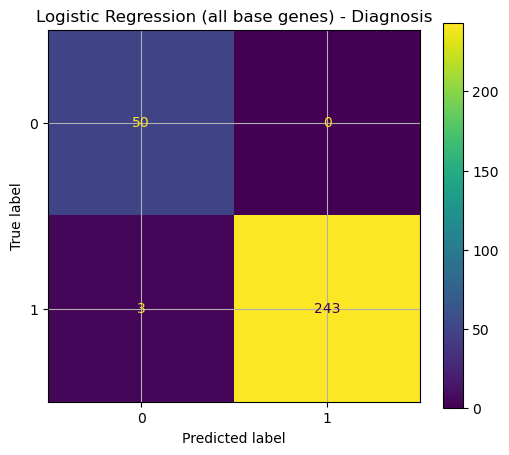

In [6]:
# Cell 5: L1-regularized Logistic Regression for cancer-oriented gene panel

print("\n--- Fitting L1 Logistic Regression (diagnosis, cancer vs normal) ---")

X_l1 = np.vstack([X_train_scaled, X_val_scaled])
y_l1 = np.concatenate([y_train_full, y_val_full])

print("X_l1 shape:", X_l1.shape)
print("y_l1 shape:", y_l1.shape)

logit_l1 = LogisticRegression(
    penalty="l1",
    solver="saga",
    C=0.1,                    # stronger L1 (smaller C => more sparsity)
    max_iter=5000,
    class_weight="balanced",
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

logit_l1.fit(X_l1, y_l1)

coef = logit_l1.coef_.ravel()
abs_coef = np.abs(coef)
nonzero = np.sum(coef != 0)

print(f"\nTotal base features: {len(coef)}")
print(f"Non-zero coefficients after L1: {nonzero}")

TOP_K_CANCER_PANEL = 20
top_idx_cancer = np.argsort(abs_coef)[-TOP_K_CANCER_PANEL:][::-1]
cancer_panel_genes = gene_names_base[top_idx_cancer].tolist()

print(f"\nTop {TOP_K_CANCER_PANEL} cancer-oriented genes by |L1 coefficient|:")
for rank, idx in enumerate(top_idx_cancer, 1):
    print(f"{rank:2d}. {gene_names_base[idx]:15s}  coef={coef[idx]: .4f}")

print("\nCANCER-ORIENTED GENE PANEL (L1, diagnosis task):")
print(cancer_panel_genes)

# Baseline performance of the L1 model (using all base features)
y_test_pred_lr  = logit_l1.predict(X_test_scaled)
y_test_proba_lr = logit_l1.predict_proba(X_test_scaled)[:, 1]

print("\n--- Logistic Regression baseline on TEST (all base genes) ---")
print(classification_report(y_test_full, y_test_pred_lr, target_names=["Normal", "Cancer"]))
print("AUC-ROC:", roc_auc_score(y_test_full, y_test_proba_lr))
ConfusionMatrixDisplay.from_predictions(y_test_full, y_test_pred_lr)
plt.title("Logistic Regression (all base genes) - Diagnosis")
plt.show()

# Cross validation

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score

pipe_lr = Pipeline([
    ("scaler", MinMaxScaler()),
    ("lr", LogisticRegression(
        penalty="l1",
        solver="saga",
        C=0.1,
        max_iter=5000,
        class_weight="balanced",
        n_jobs=-1,
        random_state=RANDOM_STATE,
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_auc = cross_val_score(
    pipe_lr,
    X_all_base,  
    y_all,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
)

print("CV AUCs:", cv_auc)
print("Mean CV AUC:", cv_auc.mean(), "+/-", cv_auc.std())

CV AUCs: [0.99314721 0.98482143 0.99936224 0.9997449  1.        ]
Mean CV AUC: 0.9954151559100797 +/- 0.005877373888307901


# Permutation test (shuffle labels)

In [8]:
from sklearn.utils import shuffle

y_all_shuffled = shuffle(y_all, random_state=123)

cv_auc_shuffled = cross_val_score(
    pipe_lr,
    X_all_base,
    y_all_shuffled,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
)

print("CV AUCs (shuffled labels):", cv_auc_shuffled)
print("Mean CV AUC (shuffled):", cv_auc_shuffled.mean(), "+/-", cv_auc_shuffled.std())

CV AUCs (shuffled labels): [0.55082487 0.5        0.5        0.56632653 0.5       ]
Mean CV AUC (shuffled): 0.5234302807417384 +/- 0.029111805543949328


## 5. Normal-oriented gene panels (Δmean / variance on TRAIN)

In contrast to the cancer-oriented panel, we now build **normal-oriented gene panels**.

Key idea:

- We want genes that are:
  - **Stable within normal samples** (reasonably low variance among normals),  
  - But show a **strong shift in mean expression** between normals and tumors.

To avoid data leakage, we only use the **training subset** (`X_train_full`, `y_train_full`) for this:

1. Split the training set into:
   - `normals_train`  (label 0)
   - `tumors_train`   (label 1)

2. For each gene `g` in the base set compute:

   $
   \mu_{\text{norm}, g}, \quad \mu_{\text{tum}, g}, \quad \mathrm{Var}_{\text{norm}, g}
   $

   and define a **stability / discriminability score**:

   $
   \text{score}_g = \frac{|\mu_{\text{tum}, g} - \mu_{\text{norm}, g}|}{\mathrm{Var}_{\text{norm}, g} + \varepsilon}
   $

3. Optionally filter out genes with extremely low variance among normals (bottom 10%),  
   to avoid numerical instability or noise.

4. Rank genes by this score and construct:

   - `normal_panel_20`  → top 20 genes  
   - `normal_panel_100` → top 100 genes  

These normal-oriented panels are specifically designed to support a VAE that models the **manifold of normal samples**, making tumors appear as reconstruction anomalies.

In [9]:
# Cell 6 : Normal-oriented gene panels using Δmean / var on TRAIN ONLY

# We use only the TRAIN subset (X_train_full, y_train_full)
X_train_df = pd.DataFrame(X_train_full, columns=gene_names_base)

normals_train = X_train_df[y_train_full == 0]
tumors_train  = X_train_df[y_train_full == 1]

print("Normals in TRAIN for panel selection:", normals_train.shape[0])
print("Tumors in TRAIN for panel selection: ", tumors_train.shape[0])

mean_norm_train = normals_train.mean(axis=0)
var_norm_train  = normals_train.var(axis=0)
mean_tum_train  = tumors_train.mean(axis=0)

delta_mean_train = (mean_tum_train - mean_norm_train).abs()
eps = 1e-6
stability_score_train = delta_mean_train / (var_norm_train + eps)

# filter low-variance genes among normals (in TRAIN)
var_threshold_train = var_norm_train.quantile(0.10)
valid_genes_train = var_norm_train[var_norm_train > var_threshold_train].index

stability_score_filtered = stability_score_train[valid_genes_train]

print("Number of valid genes after variance filter (TRAIN-based):", len(valid_genes_train))

def build_normal_panel_train(K: int):
    top_genes = (
        stability_score_filtered
        .sort_values(ascending=False)
        .head(K)
        .index
        .tolist()
    )
    return top_genes

normal_panel_20 = build_normal_panel_train(20)
normal_panel_100 = build_normal_panel_train(100)

print("\nTop 20 TRAIN-based normal-oriented genes (Δmean/var):")
for i, g in enumerate(normal_panel_20, 1):
    print(f"{i:2d}. {g}  score={stability_score_filtered[g]:.4f}")

print("\nTop 100 TRAIN-based normal-oriented genes (Δmean/var):")
print(normal_panel_100)

Normals in TRAIN for panel selection: 112
Tumors in TRAIN for panel selection:  551
Number of valid genes after variance filter (TRAIN-based): 2700

Top 20 TRAIN-based normal-oriented genes (Δmean/var):
 1. SLC50A1  score=0.0102
 2. PYCR1  score=0.0100
 3. DAP3  score=0.0095
 4. PPP4C  score=0.0084
 5. ADIPOR1  score=0.0082
 6. HIST1H2BD  score=0.0079
 7. GPRC5A  score=0.0077
 8. HN1L  score=0.0073
 9. CTHRC1  score=0.0070
10. STIP1  score=0.0068
11. MBOAT7  score=0.0067
12. MFAP2  score=0.0065
13. CACYBP  score=0.0065
14. HN1  score=0.0064
15. SIAH2  score=0.0062
16. SLC44A4  score=0.0062
17. HIST2H2BE  score=0.0058
18. H2AFV  score=0.0057
19. H2AFY  score=0.0055
20. NAA20  score=0.0054

Top 100 TRAIN-based normal-oriented genes (Δmean/var):
['SLC50A1', 'PYCR1', 'DAP3', 'PPP4C', 'ADIPOR1', 'HIST1H2BD', 'GPRC5A', 'HN1L', 'CTHRC1', 'STIP1', 'MBOAT7', 'MFAP2', 'CACYBP', 'HN1', 'SIAH2', 'SLC44A4', 'HIST2H2BE', 'H2AFV', 'H2AFY', 'NAA20', 'PSMA5', 'ALYREF', 'SEPHS2', 'BOLA2B', 'LSR', 'NME1'

## 6. VAE model for reconstruction-based anomaly detection

We define a simple **Variational Autoencoder (VAE)** that operates directly in gene-expression space:

- **Encoder**:
  - Input: vector of size `original_dim` (number of genes in the panel).
  - Hidden layer with ReLU activation.
  - Outputs two vectors:
    - `z_mean` (latent mean)
    - `z_log_var` (log-variance of latent Gaussian)

- **Decoder**:
  - Input: latent vector `z`.
  - Hidden layer with ReLU.
  - Output layer with sigmoid activation (values in [0, 1]).

- **Latent sampling**:
  - Standard reparameterization trick:
    $
    z = \mu + \sigma \odot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)
    $

- **Loss**:
  - Reconstruction loss: binary cross-entropy between input and reconstructed output, summed over features and averaged over the batch.
  - KL divergence between approximate posterior and standard normal prior.

The total VAE loss is:

$
\mathcal{L} = \mathbb{E}[\text{reconstruction}] + \text{KL}
$

This VAE is trained **only on normal samples** and later used as an unsupervised anomaly detector based on reconstruction error.

In [10]:
# Cell 7: VAE model for reconstruction-based anomaly detection 

class VAE(Model):
    def __init__(self, original_dim, intermediate_dim=64, latent_dim=32, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.original_dim = original_dim
        self.encoder = self._build_encoder(intermediate_dim, latent_dim)
        self.decoder = self._build_decoder(intermediate_dim, latent_dim)

    def _build_encoder(self, intermediate_dim, latent_dim):
        inputs = tf.keras.Input(shape=(self.original_dim,))
        x = layers.Dense(intermediate_dim, activation="relu")(inputs)
        z_mean = layers.Dense(latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
        return Model(inputs, [z_mean, z_log_var], name="encoder")

    def _build_decoder(self, intermediate_dim, latent_dim):
        latent_inputs = tf.keras.Input(shape=(latent_dim,))
        x = layers.Dense(intermediate_dim, activation="relu")(latent_inputs)
        outputs = layers.Dense(self.original_dim, activation="sigmoid")(x)
        return Model(latent_inputs, outputs, name="decoder")

    def sample(self, z_mean, z_log_var):
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def call(self, inputs):
        # Encode
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sample(z_mean, z_log_var)
        # Decode
        reconstructed = self.decoder(z)

        # use backend.binary_crossentropy (elementwise)
        bce = tf.keras.backend.binary_crossentropy(inputs, reconstructed)  # shape: (batch, D)
        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(bce, axis=1))

        # KL term
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )

        self.add_loss(reconstruction_loss + kl_loss)
        return reconstructed

## 7. Helper functions for panel-specific VAE anomaly experiments

This cell provides two key helper functions:

### 7.1 `build_anomaly_splits_for_panel(panel_genes, ...)`

For a given gene panel (list of gene symbols), this function:

1. Restricts the original expression matrices (GTEx normals, TCGA normals, TCGA tumors) to the selected genes.
2. Cleans potential missing values (NaNs) by:
   - coercing non-numeric values to NaN,
   - replacing NaNs with the median of each gene among the corresponding set.
3. Creates disjoint splits:
   - **Train normals**:
     - Remaining GTEx normal samples (after removing val/test normals),
     - All TCGA normal samples.
   - **Validation set** (`X_val`, `y_val`):
     - A mix of GTEx normals and TCGA tumors.
   - **Test set** (`X_test`, `y_test`):
     - Another disjoint mix of GTEx normals and TCGA tumors.

The validation set is used to choose the **decision threshold**, while the test set is reserved for final evaluation.

### 7.2 `evaluate_vae_anomaly_for_panel(...)`

For a specific panel, this function runs the **full anomaly pipeline**:

1. Builds train/validation/test splits via `build_anomaly_splits_for_panel`.
2. Fits a `MinMaxScaler` on **train normals only**, then applies it to val/test.
3. Trains a VAE on `X_train_norm_scaled` (unsupervised, normals only).
4. Computes reconstruction errors (L2 distance) on:
   - validation set → `val_dist`
   - test set      → `test_dist`
5. Handles possible numerical issues:
   - If any distances become NaN (e.g., from extreme activations), they are replaced with the median distance.
6. On the **validation set**, searches over many thresholds to find the one that **maximizes F1** for the cancer class (label 1).
7. Applies this **F1-optimal threshold** to the test set and reports:
   - Classification report (precision, recall, F1 for normal and cancer),
   - ROC-AUC using the continuous anomaly scores (`test_dist`),
   - Confusion matrix for visual inspection.

The returned dictionary contains a compact summary (panel name, number of genes, best validation F1, and test AUC).

In [11]:
# Cell 8: Helper to build anomaly dataset and evaluate VAE for a given gene panel

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_anomaly_splits_for_panel(
    panel_genes,
    n_val_normal=60,
    n_test_normal=60,
    n_val_cancer=25,
    n_test_cancer=25,
    random_state=42,
):
    rng = np.random.RandomState(random_state)

    # Restrict original matrices to panel genes
    gtex_panel = normal_gtex_full[panel_genes].copy()
    tcga_norm_panel = normal_tcga_full[panel_genes].copy()
    tcga_tumor_panel = tumor_tcga_full[panel_genes].copy()

    # replace missing values with column medians
    gtex_panel = gtex_panel.apply(pd.to_numeric, errors="coerce")
    tcga_norm_panel = tcga_norm_panel.apply(pd.to_numeric, errors="coerce")
    tcga_tumor_panel = tcga_tumor_panel.apply(pd.to_numeric, errors="coerce")

    gtex_panel = gtex_panel.fillna(gtex_panel.median())
    tcga_norm_panel = tcga_norm_panel.fillna(tcga_norm_panel.median())
    tcga_tumor_panel = tcga_tumor_panel.fillna(tcga_tumor_panel.median())

    idx_norm = np.arange(len(gtex_panel))
    idx_tumor = np.arange(len(tcga_tumor_panel))
    rng.shuffle(idx_norm)
    rng.shuffle(idx_tumor)

    # Normal samples for val and test from GTEx normals
    val_norm_idx   = idx_norm[:n_val_normal]
    test_norm_idx  = idx_norm[n_val_normal:n_val_normal + n_test_normal]
    train_norm_idx = idx_norm[n_val_normal + n_test_normal:]

    val_norm_df   = gtex_panel.iloc[val_norm_idx]
    test_norm_df  = gtex_panel.iloc[test_norm_idx]
    train_norm_df = gtex_panel.iloc[train_norm_idx]

    # Tumor samples for val and test
    val_tum_idx  = idx_tumor[:n_val_cancer]
    test_tum_idx = idx_tumor[n_val_cancer:n_val_cancer + n_test_cancer]

    val_tum_df  = tcga_tumor_panel.iloc[val_tum_idx]
    test_tum_df = tcga_tumor_panel.iloc[test_tum_idx]

    # Train normals: remaining GTEx normals + ALL TCGA normals
    X_train_norm = pd.concat([train_norm_df, tcga_norm_panel]).values.astype(np.float32)

    # Validation set: mix of normals and tumors
    X_val = np.vstack([
        val_norm_df.values.astype(np.float32),
        val_tum_df.values.astype(np.float32),
    ])
    y_val = np.concatenate([
        np.zeros(len(val_norm_df), dtype=int),
        np.ones(len(val_tum_df), dtype=int),
    ])

    # Test set: mix of normals and tumors
    X_test = np.vstack([
        test_norm_df.values.astype(np.float32),
        test_tum_df.values.astype(np.float32),
    ])
    y_test = np.concatenate([
        np.zeros(len(test_norm_df), dtype=int),
        np.ones(len(test_tum_df), dtype=int),
    ])

    print("\nAnomaly dataset for panel (size={} genes):".format(len(panel_genes)))
    print("  Train normals:", X_train_norm.shape[0])
    print("  Val normals:  ", len(val_norm_df))
    print("  Val cancers:  ", len(val_tum_df))
    print("  Test normals: ", len(test_norm_df))
    print("  Test cancers: ", len(test_tum_df))

    # Safety check
    print("  Any NaN in X_train_norm? ", np.isnan(X_train_norm).any())
    print("  Any NaN in X_val?        ", np.isnan(X_val).any())
    print("  Any NaN in X_test?       ", np.isnan(X_test).any())

    return X_train_norm, X_val, y_val, X_test, y_test


def evaluate_vae_anomaly_for_panel(
    panel_genes,
    panel_name="panel",
    n_val_normal=60,
    n_test_normal=60,
    n_val_cancer=25,
    n_test_cancer=25,
    random_state=42,
    epochs=200,
):

    print("\n" + "=" * 70)
    print(f"Evaluating VAE anomaly for panel: {panel_name} (|genes|={len(panel_genes)})")
    print("=" * 70)

    # Build datasets
    X_train, X_val, y_val, X_test, y_test = build_anomaly_splits_for_panel(
        panel_genes,
        n_val_normal=n_val_normal,
        n_test_normal=n_test_normal,
        n_val_cancer=n_val_cancer,
        n_test_cancer=n_test_cancer,
        random_state=random_state,
    )

    # Scale using training normals only
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled   = scaler.transform(X_val)
    X_test_scaled  = scaler.transform(X_test)

    # Train VAE on normals
    tf.keras.backend.clear_session()
    original_dim = X_train_scaled.shape[1]
    vae = VAE(
        original_dim=original_dim,
        intermediate_dim=max(8, original_dim // 2),
        latent_dim=max(4, original_dim // 3),
    )
    vae.compile(optimizer=optimizers.Adam(learning_rate=1e-3))

    early_stop = EarlyStopping(
        monitor="val_loss",
        patience=20,
        restore_best_weights=True,
    )

    reduce_lr = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=10,
        min_lr=1e-5,
    )

    history = vae.fit(
        X_train_scaled,
        X_train_scaled,
        epochs=epochs,
        batch_size=64,
        shuffle=True,
        validation_split=0.1,             
        callbacks=[early_stop, reduce_lr], 
        verbose=0,
    )

    # Reconstruction errors
    X_val_pred = vae.predict(X_val_scaled, verbose=0)
    val_dist = np.linalg.norm(X_val_scaled - X_val_pred, axis=1)

    X_test_pred = vae.predict(X_test_scaled, verbose=0)
    test_dist = np.linalg.norm(X_test_scaled - X_test_pred, axis=1)

    # Replace any NaNs in distances with median distance (robust fallback)
    if np.isnan(val_dist).any():
        median_val = np.nanmedian(val_dist)
        val_dist = np.nan_to_num(val_dist, nan=median_val)
        print("  [WARN] NaNs detected in VAL distances, replaced with median.")

    if np.isnan(test_dist).any():
        median_test = np.nanmedian(test_dist)
        test_dist = np.nan_to_num(test_dist, nan=median_test)
        print("  [WARN] NaNs detected in TEST distances, replaced with median.")

    print("\nError ranges:")
    print("  VAL:  min={:.4f}, max={:.4f}".format(val_dist.min(), val_dist.max()))
    print("  TEST: min={:.4f}, max={:.4f}".format(test_dist.min(), test_dist.max()))

    # Find best threshold on VAL by F1 (cancer as positive)
    def find_best_threshold_f1(y_true, scores, n_thresh=400):
        t_min, t_max = scores.min(), scores.max()
        thresholds = np.linspace(t_min, t_max, n_thresh)
        best_f1 = -1.0
        best_t = None
        for t in thresholds:
            y_pred = (scores >= t).astype(int)
            f1 = f1_score(y_true, y_pred, pos_label=1)
            if f1 > best_f1:
                best_f1 = f1
                best_t = t
        return best_t, best_f1

    best_t, best_f1_val = find_best_threshold_f1(y_val, val_dist, n_thresh=400)
    print("\n[VAL] Best threshold (F1-optimal):", best_t)
    print("[VAL] Best F1 (cancer as positive):", best_f1_val)

    # Apply this threshold to TEST
    y_score_test = test_dist
    y_pred_test  = (y_score_test >= best_t).astype(int)

    print("\n[TEST] Classification report @ F1-optimal threshold:")
    print(classification_report(y_test, y_pred_test, target_names=["Normal", "Cancer"]))
    print("[TEST] AUC (score-based):", roc_auc_score(y_test, y_score_test))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
    plt.title(f"TEST confusion matrix - {panel_name}")
    plt.show()

    return {
        "panel_name": panel_name,
        "n_genes": len(panel_genes),
        "val_best_threshold": best_t,
        "val_best_f1": best_f1_val,
        "test_auc": roc_auc_score(y_test, y_score_test),
    }

## 8. Comparing gene panels via VAE anomaly detection

In this final section, we systematically compare how different gene panels behave when used with the **same VAE-based anomaly detection pipeline**:

1. **Cancer-oriented L1 panel (K = 20 genes)**  
   - Derived from supervised logistic regression on the diagnosis task.
   - Conceptually “tumor-centric”: these genes are most discriminative for cancer vs normal.

2. **Normal-oriented panel (K = 20 genes)**  
   - Derived from the Δmean/variance score on the training subset.
   - Focuses on genes that are relatively stable among normals but shifted in tumors.

3. **Normal-oriented panel (K = 100 genes)**  
   - Larger version of the normal-oriented panel.
   - Provides more degrees of freedom for the VAE to model the manifold of normal samples.

For each panel, we:

- Train the VAE **only on normal samples**,
- Select an F1-optimal threshold on a labeled **validation set**,
- Evaluate performance (classification metrics + ROC-AUC) on the held-out **test set**.

Finally, we collect the results in a summary DataFrame, making it easy to compare:

- Panel size (`n_genes`)  
- Validation F1 for cancer  
- Test ROC-AUC (score-based anomaly separation)

This allows us to analyze how **panel design (cancer-oriented vs normal-oriented, narrow vs larger panels)** influences VAE-based anomaly detection in transcriptomic data.


Evaluating VAE anomaly for panel: Cancer-oriented L1 panel (K=20) (|genes|=20)

Anomaly dataset for panel (size=20 genes):
  Train normals: 110
  Val normals:   60
  Val cancers:   25
  Test normals:  29
  Test cancers:  25
  Any NaN in X_train_norm?  False
  Any NaN in X_val?         False
  Any NaN in X_test?        False

Error ranges:
  VAL:  min=0.8489, max=3.9281
  TEST: min=1.0349, max=3.9800

[VAL] Best threshold (F1-optimal): 1.8984180718735046
[VAL] Best F1 (cancer as positive): 0.9411764705882353

[TEST] Classification report @ F1-optimal threshold:
              precision    recall  f1-score   support

      Normal       0.93      0.90      0.91        29
      Cancer       0.88      0.92      0.90        25

    accuracy                           0.91        54
   macro avg       0.91      0.91      0.91        54
weighted avg       0.91      0.91      0.91        54

[TEST] AUC (score-based): 0.96


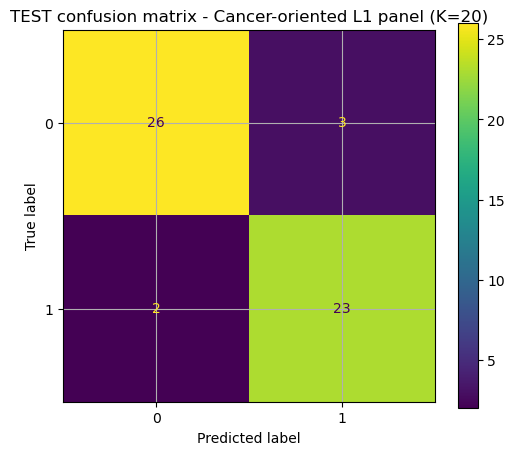


Evaluating VAE anomaly for panel: Normal-oriented panel (K=20, Δmean/var) (|genes|=20)

Anomaly dataset for panel (size=20 genes):
  Train normals: 110
  Val normals:   60
  Val cancers:   25
  Test normals:  29
  Test cancers:  25
  Any NaN in X_train_norm?  False
  Any NaN in X_val?         False
  Any NaN in X_test?        False

Error ranges:
  VAL:  min=0.6443, max=10.8534
  TEST: min=0.8726, max=11.2290

[VAL] Best threshold (F1-optimal): 3.177360742611993
[VAL] Best F1 (cancer as positive): 0.9166666666666666

[TEST] Classification report @ F1-optimal threshold:
              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97        29
      Cancer       0.96      0.96      0.96        25

    accuracy                           0.96        54
   macro avg       0.96      0.96      0.96        54
weighted avg       0.96      0.96      0.96        54

[TEST] AUC (score-based): 0.9944827586206897


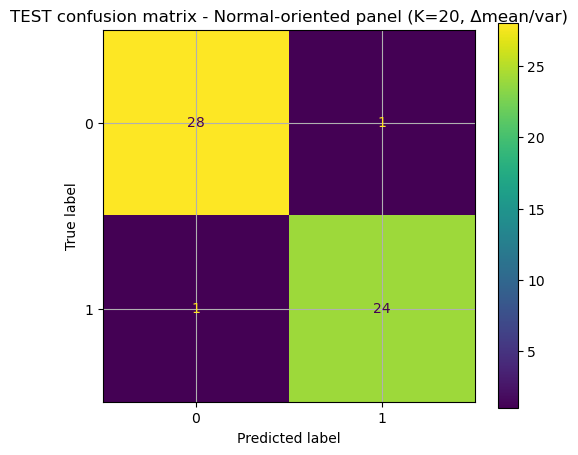


Evaluating VAE anomaly for panel: Normal-oriented panel (K=100, Δmean/var) (|genes|=100)

Anomaly dataset for panel (size=100 genes):
  Train normals: 110
  Val normals:   60
  Val cancers:   25
  Test normals:  29
  Test cancers:  25
  Any NaN in X_train_norm?  False
  Any NaN in X_val?         False
  Any NaN in X_test?        False

Error ranges:
  VAL:  min=1.5585, max=27.5553
  TEST: min=1.7620, max=23.1612

[VAL] Best threshold (F1-optimal): 4.555659635622699
[VAL] Best F1 (cancer as positive): 0.9259259259259259

[TEST] Classification report @ F1-optimal threshold:
              precision    recall  f1-score   support

      Normal       0.96      0.83      0.89        29
      Cancer       0.83      0.96      0.89        25

    accuracy                           0.89        54
   macro avg       0.89      0.89      0.89        54
weighted avg       0.90      0.89      0.89        54

[TEST] AUC (score-based): 0.993103448275862


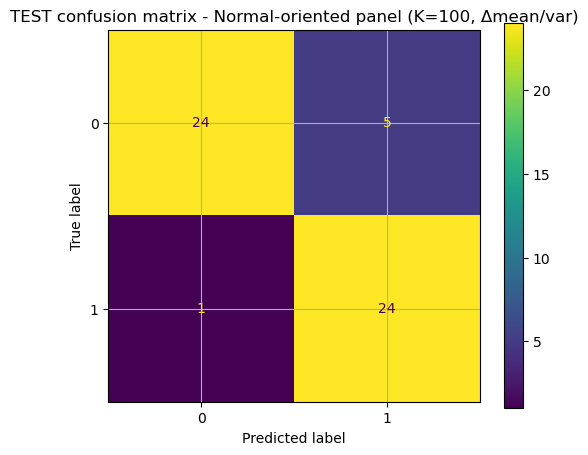


=== Summary of VAE anomaly experiments ===


,panel_name,n_genes,val_best_threshold,val_best_f1,test_auc
0,Cancer-oriented L1 panel (K=20),20,1.898418,0.941176,0.960000
1,"Normal-oriented panel (K=20, Δmean/var)",20,3.177361,0.916667,0.994483
2,"Normal-oriented panel (K=100, Δmean/var)",100,4.555660,0.925926,0.993103


In [12]:
# Cell 9: Run anomaly experiments for different gene panels

results = []

# Cancer-oriented panel (L1, 20 genes) – normal as inlier
res_cancer_panel = evaluate_vae_anomaly_for_panel(
    panel_genes=cancer_panel_genes,
    panel_name="Cancer-oriented L1 panel (K=20)",
    n_val_normal=60,
    n_test_normal=60,
    n_val_cancer=25,
    n_test_cancer=25,
    random_state=RANDOM_STATE,
    epochs=200,
)
results.append(res_cancer_panel)

# Normal-oriented panel (Δmean/var, K=20)
res_normal20 = evaluate_vae_anomaly_for_panel(
    panel_genes=normal_panel_20,
    panel_name="Normal-oriented panel (K=20, Δmean/var)",
    n_val_normal=60,
    n_test_normal=60,
    n_val_cancer=25,
    n_test_cancer=25,
    random_state=RANDOM_STATE,
    epochs=200,
)
results.append(res_normal20)

# Normal-oriented panel (Δmean/var, K=100)
res_normal100 = evaluate_vae_anomaly_for_panel(
    panel_genes=normal_panel_100,
    panel_name="Normal-oriented panel (K=100, Δmean/var)",
    n_val_normal=60,
    n_test_normal=60,
    n_val_cancer=25,
    n_test_cancer=25,
    random_state=RANDOM_STATE,
    epochs=200,
)
results.append(res_normal100)

print("\n=== Summary of VAE anomaly experiments ===")
summary_df = pd.DataFrame(results)
display(summary_df)

### Figure 1 – L1 coefficients of the cancer-oriented gene panel

This figure shows the absolute L1-regularized logistic regression coefficients
for the top 20 cancer-oriented genes. These genes were selected as the most
discriminative features for separating tumor from normal samples in the
supervised diagnosis task. Larger absolute coefficients indicate stronger
contribution to the decision boundary.

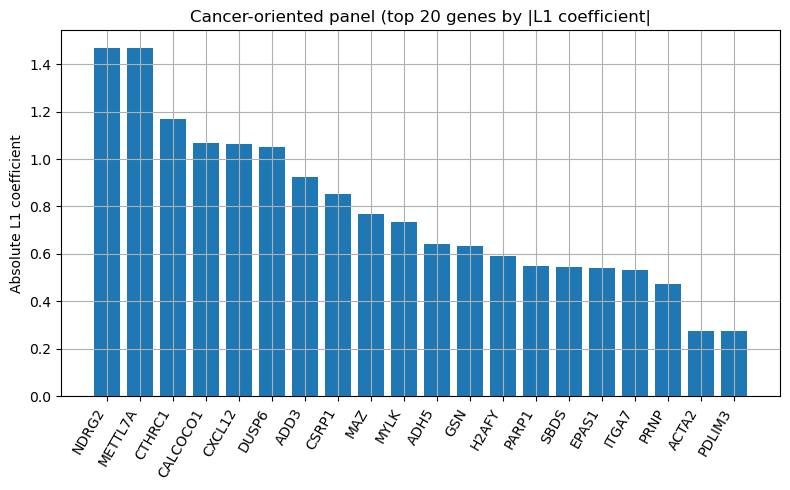

In [13]:
# Bar plot of L1 coefficients for the cancer-oriented gene panel

import numpy as np
import matplotlib.pyplot as plt

# Extract coefficients just for the cancer panel genes
panel_coefs = []
for g in cancer_panel_genes:
    idx = np.where(gene_names_base == g)[0][0]
    panel_coefs.append(coef[idx])

panel_coefs = np.array(panel_coefs)
panel_abs = np.abs(panel_coefs)

# Sort by |coef| descending
order = np.argsort(panel_abs)[::-1]
genes_sorted = np.array(cancer_panel_genes)[order]
coefs_sorted = panel_coefs[order]
abs_sorted = panel_abs[order]

plt.figure(figsize=(8, 5))
plt.bar(range(len(genes_sorted)), abs_sorted)
plt.xticks(range(len(genes_sorted)), genes_sorted, rotation=60, ha="right")
plt.ylabel("Absolute L1 coefficient")
plt.title("Cancer-oriented panel (top 20 genes by |L1 coefficient|")
plt.tight_layout()
plt.show()

### Figure 2 – Expression heatmap of the cancer-oriented gene panel

This heatmap visualizes the expression patterns of the 20-gene cancer-oriented
panel across a subset of normal and tumor samples. Rows correspond to samples
and columns to genes. Normal samples are shown on top, tumors at the bottom.
The panel captures clear shifts in expression patterns between the two groups.

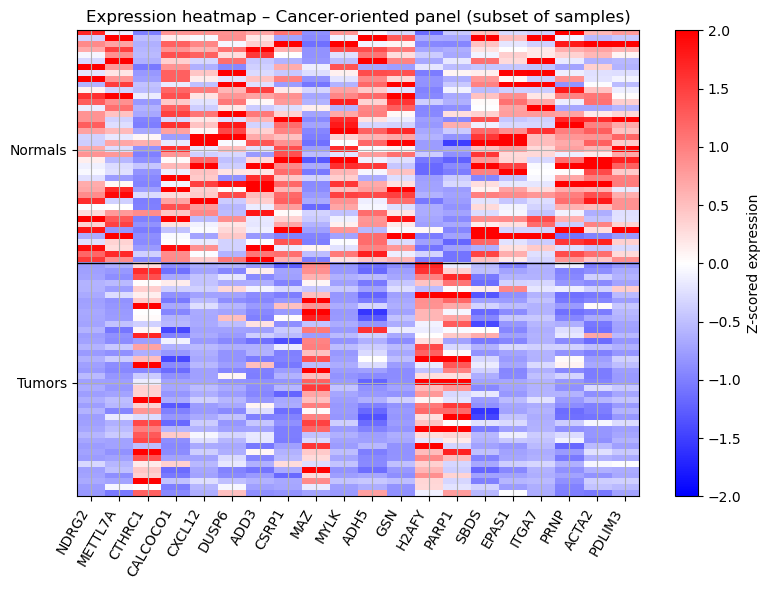

In [14]:
# Heatmap of expression for cancer-oriented panel (normal vs tumor)

# Take a subset of samples for visualization 
n_vis_normal = 40
n_vis_cancer = 40

# Build DataFrames for convenience
X_all_base_df = pd.DataFrame(X_all_base, columns=gene_names_base)

norm_indices = np.where(y_all == 0)[0]
cancer_indices = np.where(y_all == 1)[0]

vis_norm_idx = norm_indices[:n_vis_normal]
vis_canc_idx = cancer_indices[:n_vis_cancer]

X_vis_norm = X_all_base_df.iloc[vis_norm_idx][cancer_panel_genes]
X_vis_canc = X_all_base_df.iloc[vis_canc_idx][cancer_panel_genes]

X_vis = pd.concat([X_vis_norm, X_vis_canc], axis=0)
labels_vis = np.array([0] * len(X_vis_norm) + [1] * len(X_vis_canc))

# Scale per gene (column-wise z-score) for visualization
X_vis_z = (X_vis - X_vis.mean(axis=0)) / (X_vis.std(axis=0) + 1e-8)

plt.figure(figsize=(8, 6))
plt.imshow(X_vis_z.values, aspect="auto", cmap="bwr", vmin=-2, vmax=2)
plt.colorbar(label="Z-scored expression")
plt.axhline(len(X_vis_norm) - 0.5, color="black", linewidth=1)
plt.xticks(range(len(cancer_panel_genes)), cancer_panel_genes, rotation=60, ha="right")
plt.yticks(
    [len(X_vis_norm) / 2, len(X_vis_norm) + len(X_vis_canc) / 2],
    ["Normals", "Tumors"]
)
plt.title("Expression heatmap – Cancer-oriented panel (subset of samples)")
plt.tight_layout()
plt.show()

### Figure 3 – ROC curve for the L1 logistic regression baseline

Receiver operating characteristic (ROC) curve of the L1-regularized logistic
regression classifier on the held-out test set using all 3000 base genes.
This provides a supervised baseline performance for tumor vs normal diagnosis
against which the VAE-based anomaly detectors can be compared.

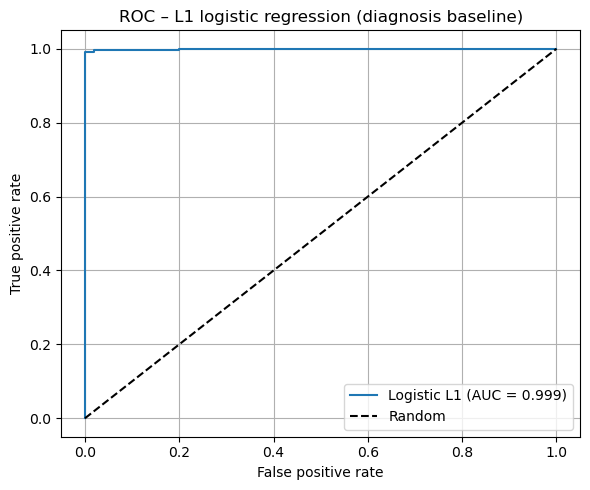

In [15]:
# ROC curve for the L1 logistic regression baseline

from sklearn.metrics import roc_curve, auc

fpr_lr, tpr_lr, _ = roc_curve(y_test_full, y_test_proba_lr)
auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(6, 5))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic L1 (AUC = {auc_lr:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC – L1 logistic regression (diagnosis baseline)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

### Helper – Detailed VAE anomaly evaluation (for plotting)

The following helper computes detailed VAE anomaly outputs for a given panel:
validation and test reconstruction-error scores, the F1-optimal threshold
(chosen on validation), and the corresponding labels. This is used to generate
ROC curves and error distributions for different panels.

In [16]:
# Helper for detailed VAE anomaly outputs (for plots)

def compute_vae_anomaly_details_for_panel(
    panel_genes,
    panel_name="panel",
    n_val_normal=60,
    n_test_normal=60,
    n_val_cancer=25,
    n_test_cancer=25,
    random_state=RANDOM_STATE,
    epochs=200,
):
    print("\n" + "=" * 70)
    print(f"[DETAIL] VAE anomaly for panel: {panel_name} (|genes|={len(panel_genes)})")
    print("=" * 70)

    X_train, X_val, y_val, X_test, y_test = build_anomaly_splits_for_panel(
        panel_genes,
        n_val_normal=n_val_normal,
        n_test_normal=n_test_normal,
        n_val_cancer=n_val_cancer,
        n_test_cancer=n_test_cancer,
        random_state=random_state,
    )

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled   = scaler.transform(X_val)
    X_test_scaled  = scaler.transform(X_test)

    tf.keras.backend.clear_session()
    original_dim = X_train_scaled.shape[1]
    vae = VAE(
        original_dim=original_dim,
        intermediate_dim=max(8, original_dim // 2),
        latent_dim=max(4, original_dim // 3),
    )
    vae.compile(optimizer=optimizers.Adam(learning_rate=1e-3))

    _ = vae.fit(
        X_train_scaled,
        X_train_scaled,
        epochs=epochs,
        batch_size=64,
        shuffle=True,
        validation_split=0.1,
        verbose=0,
    )

    # Reconstruction distances
    X_val_pred = vae.predict(X_val_scaled, verbose=0)
    val_dist = np.linalg.norm(X_val_scaled - X_val_pred, axis=1)

    X_test_pred = vae.predict(X_test_scaled, verbose=0)
    test_dist = np.linalg.norm(X_test_scaled - X_test_pred, axis=1)

    # NaN safety
    if np.isnan(val_dist).any():
        median_val = np.nanmedian(val_dist)
        val_dist = np.nan_to_num(val_dist, nan=median_val)
        print("  [WARN] NaNs detected in VAL distances, replaced with median.")
    if np.isnan(test_dist).any():
        median_test = np.nanmedian(test_dist)
        test_dist = np.nan_to_num(test_dist, nan=median_test)
        print("  [WARN] NaNs detected in TEST distances, replaced with median.")

    # F1-optimal threshold on VAL
    def find_best_threshold_f1(y_true, scores, n_thresh=400):
        t_min, t_max = scores.min(), scores.max()
        thresholds = np.linspace(t_min, t_max, n_thresh)
        best_f1 = -1.0
        best_t = None
        for t in thresholds:
            y_pred = (scores >= t).astype(int)
            f1 = f1_score(y_true, y_pred, pos_label=1)
            if f1 > best_f1:
                best_f1 = f1
                best_t = t
        return best_t, best_f1

    best_t, best_f1_val = find_best_threshold_f1(y_val, val_dist, n_thresh=400)
    print(f"  [VAL] Best threshold={best_t:.4f}, F1={best_f1_val:.3f}")

    y_pred_test = (test_dist >= best_t).astype(int)
    test_auc = roc_auc_score(y_test, test_dist)

    print("  [TEST] AUC (score-based):", test_auc)
    print("  [TEST] Classification @ F1-optimal threshold:")
    print(classification_report(y_test, y_pred_test, target_names=["Normal", "Cancer"]))

    return {
        "panel_name": panel_name,
        "n_genes": len(panel_genes),
        "y_val": y_val,
        "val_scores": val_dist,
        "y_test": y_test,
        "test_scores": test_dist,
        "best_threshold": best_t,
        "best_f1_val": best_f1_val,
        "test_auc": test_auc,
    }

### Running detailed VAE anomaly experiments for multiple panels

We now run the detailed VAE anomaly evaluation for three panels:

1. Cancer-oriented L1 panel (20 genes),
2. Normal-oriented panel (20 genes, Δmean/var),
3. Normal-oriented panel (100 genes, Δmean/var).

The outputs are stored for downstream plotting of ROC curves and error distributions.

In [17]:
# Run detailed VAE anomaly for three panels

vae_details = []

vae_details.append(
    compute_vae_anomaly_details_for_panel(
        cancer_panel_genes,
        panel_name="Cancer L1 (K=20)",
        epochs=200,
    )
)

vae_details.append(
    compute_vae_anomaly_details_for_panel(
        normal_panel_20,
        panel_name="Normal Δmean/var (K=20)",
        epochs=200,
    )
)

vae_details.append(
    compute_vae_anomaly_details_for_panel(
        normal_panel_100,
        panel_name="Normal Δmean/var (K=100)",
        epochs=200,
    )
)

vae_summary_df = pd.DataFrame([
    {
        "Panel": d["panel_name"],
        "#Genes": d["n_genes"],
        "Val best F1 (cancer)": d["best_f1_val"],
        "Test AUC": d["test_auc"],
    }
    for d in vae_details
])

display(vae_summary_df)


[DETAIL] VAE anomaly for panel: Cancer L1 (K=20) (|genes|=20)

Anomaly dataset for panel (size=20 genes):
  Train normals: 110
  Val normals:   60
  Val cancers:   25
  Test normals:  29
  Test cancers:  25
  Any NaN in X_train_norm?  False
  Any NaN in X_val?         False
  Any NaN in X_test?        False
  [VAL] Best threshold=1.7225, F1=0.943
  [TEST] AUC (score-based): 0.9586206896551724
  [TEST] Classification @ F1-optimal threshold:
              precision    recall  f1-score   support

      Normal       0.96      0.86      0.91        29
      Cancer       0.86      0.96      0.91        25

    accuracy                           0.91        54
   macro avg       0.91      0.91      0.91        54
weighted avg       0.91      0.91      0.91        54


[DETAIL] VAE anomaly for panel: Normal Δmean/var (K=20) (|genes|=20)

Anomaly dataset for panel (size=20 genes):
  Train normals: 110
  Val normals:   60
  Val cancers:   25
  Test normals:  29
  Test cancers:  25
  Any NaN in 

,Panel,#Genes,Val best F1 (cancer),Test AUC
0,Cancer L1 (K=20),20,0.943396,0.958621
1,Normal Δmean/var (K=20),20,0.938776,0.994483
2,Normal Δmean/var (K=100),100,0.923077,0.988966


### Figure 4 – ROC curves for VAE-based anomaly detection across panels

ROC curves of reconstruction-error-based anomaly detection for three different
gene panels:

- Cancer-oriented L1 panel (20 genes),
- Normal-oriented panel (20 genes, Δmean/var),
- Normal-oriented panel (100 genes, Δmean/var).

All VAEs are trained only on normal samples, and tumor samples are treated as
anomalies. The curves highlight how panel design and panel size affect the
separability of tumors from normals in terms of reconstruction error.

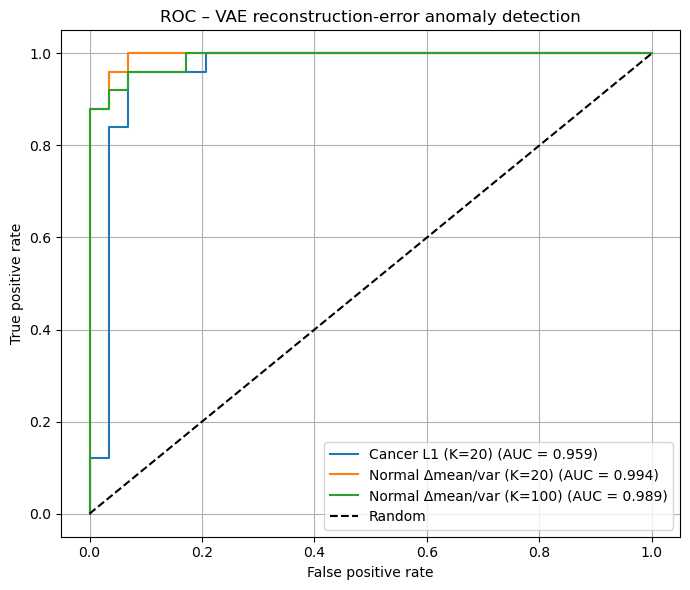

In [18]:
# ROC curves for VAE anomaly detectors across panels

plt.figure(figsize=(7, 6))

for d in vae_details:
    y_test = d["y_test"]
    scores = d["test_scores"]
    fpr, tpr, _ = roc_curve(y_test, scores)
    panel_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{d['panel_name']} (AUC = {panel_auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC – VAE reconstruction-error anomaly detection")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

### Figure 5 – Reconstruction error distributions (best normal-oriented panel)

Distribution of VAE reconstruction errors for the best normal-oriented panel
(e.g. Δmean/var, 100 genes) on the test set, separated by class (normal vs tumor).
Tumor samples tend to show higher reconstruction errors than normal samples,
indicating that the VAE has learned a normal manifold where tumors appear as
anomalies.

Using panel for error distribution plot: Normal Δmean/var (K=20)


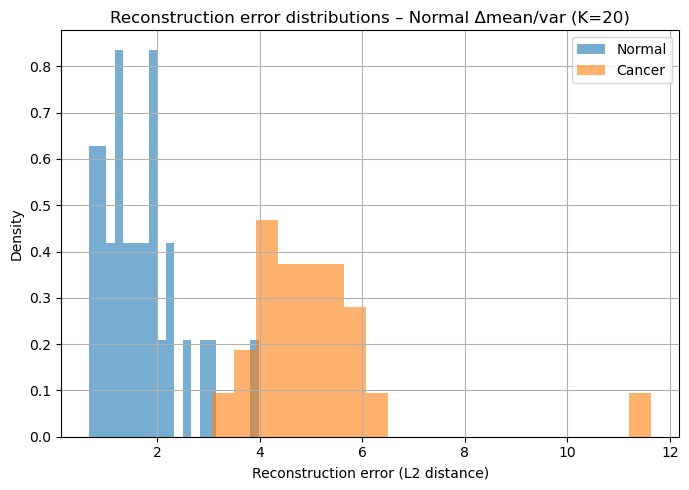

In [19]:
# Reconstruction error histograms for the best panel (e.g., normal K=100)

# Pick the panel with the highest Test AUC (or specifically normal K=100)
best_panel = max(vae_details, key=lambda d: d["test_auc"])
print("Using panel for error distribution plot:", best_panel["panel_name"])

y_test = best_panel["y_test"]
scores = best_panel["test_scores"]

scores_norm = scores[y_test == 0]
scores_canc = scores[y_test == 1]

plt.figure(figsize=(7, 5))
bins = 20

plt.hist(scores_norm, bins=bins, alpha=0.6, label="Normal", density=True)
plt.hist(scores_canc, bins=bins, alpha=0.6, label="Cancer", density=True)

plt.xlabel("Reconstruction error (L2 distance)")
plt.ylabel("Density")
plt.title(f"Reconstruction error distributions – {best_panel['panel_name']}")
plt.legend()
plt.tight_layout()
plt.show()

### Figure 6 – Summary of VAE anomaly performance across gene panels

Bar plot summarizing test-set ROC-AUC values for different gene panels used
with the VAE-based anomaly detector. This visualization highlights how
panel design (cancer-oriented vs normal-oriented) and panel size (20 vs 100 genes)
influence anomaly detection performance.

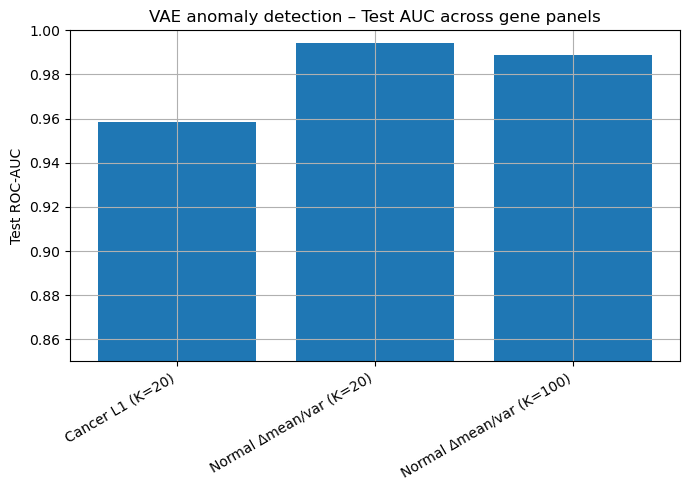

In [20]:
# Bar chart summary of test AUC across panels

panels = [d["panel_name"] for d in vae_details]
auc_values = [d["test_auc"] for d in vae_details]

plt.figure(figsize=(7, 5))
positions = np.arange(len(panels))
plt.bar(positions, auc_values)
plt.xticks(positions, panels, rotation=30, ha="right")
plt.ylabel("Test ROC-AUC")
plt.ylim(0.85, 1.000)
plt.title("VAE anomaly detection – Test AUC across gene panels")
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


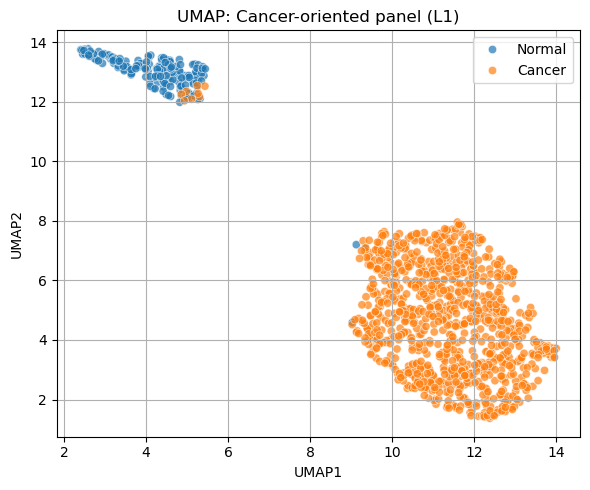

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


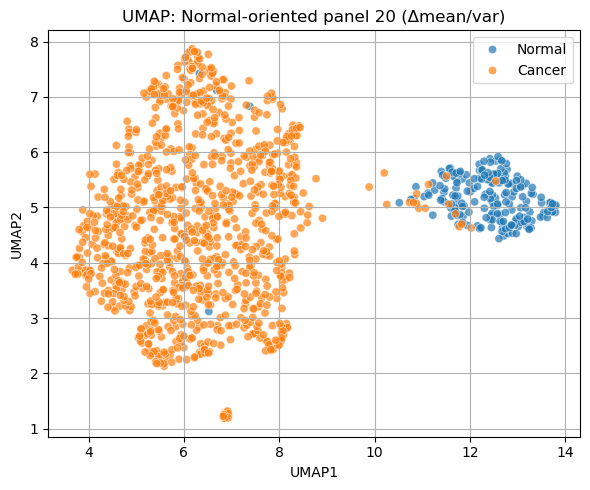

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


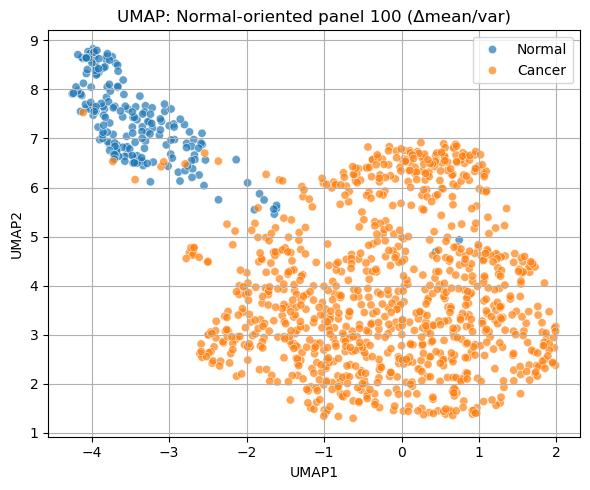

In [21]:
# UMAP visualization of cancer vs normal panels

import umap
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Helper to project & plot
def plot_umap_for_panel(panel_genes, panel_name):
    X_panel = X_all_df[panel_genes].values.astype(np.float32)

    # scale features
    X_panel_scaled = MinMaxScaler().fit_transform(X_panel)

    # UMAP embedding
    reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, random_state=42)
    emb = reducer.fit_transform(X_panel_scaled)

    df_plot = pd.DataFrame({
        "UMAP1": emb[:, 0],
        "UMAP2": emb[:, 1],
        "label": np.where(y_all == 1, "Cancer", "Normal"),
    })

    plt.figure(figsize=(6, 5))
    sns.scatterplot(
        data=df_plot,
        x="UMAP1",
        y="UMAP2",
        hue="label",
        alpha=0.7,
    )
    plt.title(f"UMAP: {panel_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_umap_for_panel(cancer_panel_genes, "Cancer-oriented panel (L1)")
plot_umap_for_panel(normal_panel_20, "Normal-oriented panel 20 (Δmean/var)")
plot_umap_for_panel(normal_panel_100, "Normal-oriented panel 100 (Δmean/var)")